In [1]:
#!/usr/bin/env python3
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import Path
from typing import cast
import h5py
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import argparse

In [2]:
# Constants
batch_size = 128
num_workers = 10
n_geno = 100000
n_alleles = 2
n_loci = n_geno * n_alleles



n_loci = 100000
n_alleles = 2
window_step = 10
window_stride = 5
glatent = 5000
input_length = n_loci * n_alleles
genetic_noise = 0.95
learning_rate = 0.001

latent_space_g = glatent
n_epochs = 1
batch_size = 128
num_workers = 9
base_file_name = 'gpatlas_input/test_sim_WF_1kbt_10000n_5000000bp_'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

# Dataset classes
class BaseDataset(Dataset):
    def __init__(self, hdf5_path: Path) -> None:
        self.h5 = h5py.File(hdf5_path, "r")
        self._strain_group = cast(h5py.Group, self.h5["strains"])
        self.strains: list[str] = list(self._strain_group.keys())

    def __len__(self) -> int:
        return len(self._strain_group)

class GenoDataset(BaseDataset):
    def __getitem__(self, idx: int) -> torch.Tensor:
        strain = self.strains[idx]
        strain_data = cast(Dataset, self._strain_group[strain])
        gens = torch.tensor(strain_data["genotype"][:], dtype=torch.float32).flatten()
        return gens


In [4]:

class local_gg_encoder(nn.Module):
    def __init__(self, input_length=input_length, loci_count=n_loci, window_size=window_step, latent_dim=glatent, window_stride=window_stride):
        """
        LD-aware autoencoder for genetic data using grouped convolution.
        Each window of loci is processed independently.

        Args:
            input_length: Total length of input tensor (one-hot encoded, so 2 values per locus)
            loci_count: Actual number of genetic loci (half of input_length)
            window_size: Number of loci to group together in local connections
            latent_dim: Dimension of the latent space
        """
        super().__init__()

        self.input_length = input_length  # 200,000 values for 100,000 loci
        self.loci_count = loci_count      # 100,000 loci
        self.window_size = window_size    # 10 loci per group
        self.latent_dim = latent_dim      # Latent space dimension
        self.window_stride = window_stride #steps between LD windows

        # Calculate the number of groups
        self.n_groups = loci_count // window_size  # 10,000 groups

        # Locally connected block to catch LD
        self.encoder_conv_block = nn.Sequential(
            nn.Conv1d(
                in_channels=self.n_groups,
                out_channels=self.n_groups,
                kernel_size=window_size * 2,
                stride=window_stride * 2,
                groups=self.n_groups,
                bias=True
            ),
            nn.LeakyReLU(0.01)
        )

        # Fully connected block for encoder
        self.encoder_fc_block = nn.Sequential(
            nn.Linear(self.n_groups, latent_dim),
            nn.BatchNorm1d(latent_dim, momentum=0.8),
            nn.LeakyReLU(0.01)
        )

    def forward(self, x):
        batch_size = x.size(0)
        # Reshape to group by windows
        x = x.reshape(batch_size, self.n_groups, self.window_size * 2)
        # Apply convolutional block
        x = self.encoder_conv_block(x)
        # Flatten
        x = x.reshape(batch_size, self.n_groups)
        # Apply FC block to get latent representation
        latent = self.encoder_fc_block(x)
        return(latent)

#####################################################################################################################

class local_gg_decoder(nn.Module):
    def __init__(self, input_length=input_length, loci_count=n_loci, window_size=window_step, latent_dim=glatent, window_stride=window_stride):
        super().__init__()

        self.input_length = input_length  # 200,000 values for 100,000 loci
        self.loci_count = loci_count      # 100,000 loci
        self.window_size = window_size    # 10 loci per group
        self.latent_dim = latent_dim      # Latent space dimension
        self.window_stride = window_stride #steps between LD windows

        # Calculate the number of groups
        self.n_groups = loci_count // window_size  # 10,000 groups

        # Fully connected block for decoder
        self.decoder_fc_block = nn.Sequential(
            nn.Linear(latent_dim, self.n_groups),
            nn.BatchNorm1d(self.n_groups, momentum=0.8),
            nn.LeakyReLU(0.01)
        )

        # Locally connected block
        self.decoder_conv_block = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=self.n_groups,
                out_channels=self.n_groups,
                kernel_size=window_size * 2,
                stride=window_stride * 2,
                groups=self.n_groups,
                bias=True
            ),
            nn.LeakyReLU(0.01)
        )
        # Final sigmoid transform
        self.decoder_final_act = nn.Sigmoid()


    def forward(self, z):
        batch_size = z.size(0)
        x = self.decoder_fc_block(z)
        x = x.reshape(batch_size, self.n_groups, 1)

        x = self.decoder_conv_block(x)
        x = x.reshape(batch_size, self.input_length)

        x = self.decoder_final_act(x)
        return x


In [5]:
def load_models(encoder_path, decoder_path=None, device='cuda'):
    """Load the encoder and decoder models from checkpoints"""
    # Initialize models with the correct parameters
    GQ = local_gg_encoder(
        input_length=input_length,
        loci_count=n_loci,
        window_size=window_step,
        latent_dim=glatent,
        window_stride=window_stride
    ).to(device)

    GP = local_gg_decoder(
        input_length=input_length,
        loci_count=n_loci,
        window_size=window_step,
        latent_dim=glatent,
        window_stride=window_stride
    ).to(device)

    # Load encoder state
    GQ.load_state_dict(torch.load(encoder_path, map_location=device))
    GQ.eval()

    # Load decoder if provided separately
    if decoder_path:
        GP.load_state_dict(torch.load(decoder_path, map_location=device))
        GP.eval()

    return GQ, GP, glatent

In [11]:

def evaluate_autoencoder(GQ, GP, test_loader, device, threshold=0.5):
    """
    Evaluate the autoencoder performance at the allele level

    Returns:
    - correct_allele: count of correctly reconstructed alleles
    - wrong_allele: count of incorrectly reconstructed alleles
    - invalid_state: count of reconstructed invalid states
    - minor_allele_freq: minor allele frequency for each locus
    """
    # Initialize counters per locus position
    n_positions = 3000
    correct_allele = np.zeros(n_positions)
    correct_allele_0 = np.zeros(n_positions)
    correct_allele_1 = np.zeros(n_positions)
    wrong_allele = np.zeros(n_positions)
    invalid_state = np.zeros(n_positions)

    # Initialize counters for allele frequencies
    allele1_count = np.zeros(n_positions)  # Count of (1,0) genotypes

    total_samples = 0

    # Process batches
    with torch.no_grad():
        for gens in test_loader:
            batch_size = gens.shape[0]
            total_samples += batch_size

            gens = gens.to(device)

            # Run through autoencoder
            latent = GQ(gens)
            reconstructed = GP(latent)

            # Convert to binary representation (threshold outputs)
            reconstructed_binary = (reconstructed > threshold).float()

            # Analyze per locus
            for pos in range(n_positions):
                # Get allele pairs for this locus
                allele1_idx = pos * n_alleles
                allele2_idx = pos * n_alleles + 1

                for sample_idx in range(batch_size):
                    true_allele1 = gens[sample_idx, allele1_idx].item()
                    true_allele2 = gens[sample_idx, allele2_idx].item()

                    # Count allele1 (1,0) genotypes for MAF calculation
                    if true_allele1 == 1 and true_allele2 == 0:
                        allele1_count[pos] += 1

                    recon_allele1 = reconstructed_binary[sample_idx, allele1_idx].item()
                    recon_allele2 = reconstructed_binary[sample_idx, allele2_idx].item()

                    # Case 1: Correct allele reconstruction
                    if (true_allele1 == recon_allele1 and true_allele2 == recon_allele2):
                        correct_allele[pos] += 1
                        #track number of correctly reconstructed 0 alleles
                        if (true_allele1 == recon_allele1 and true_allele2 == recon_allele2 and true_allele1 == 1):
                            correct_allele_0[pos] += 1
                        #track number of correctly reconstructed 0 alleles
                        if (true_allele1 == recon_allele1 and true_allele2 == recon_allele2 and true_allele2 == 1):
                            correct_allele_1[pos] += 1
                    # Case 3: Invalid allelic state
                    elif (recon_allele1 == 1 and recon_allele2 == 1) or (recon_allele1 == 0 and recon_allele2 == 0):
                        invalid_state[pos] += 1
                    # Case 2: Wrong allele
                    else:
                        wrong_allele[pos] += 1

    # Calculate MAF
    daf = (1-allele1_count/ total_samples)

    # Convert to percentages
    correct_allele = (correct_allele / total_samples) * 100
    wrong_allele = (wrong_allele / total_samples) * 100
    invalid_state = (invalid_state / total_samples) * 100

    return correct_allele, correct_allele_0, correct_allele_1, wrong_allele, invalid_state, daf, total_samples


In [12]:
encoder = "localgg/localgg_GQ_encoder_state_dict.pt"
decoder = "localgg/localgg_GP_decoder_state_dict.pt"

test_data = 'gpatlas_input/test_sim_WF_1kbt_10000n_5000000bp_test.hdf5'
bin_size = 1000
threshold = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Load data
test_data = GenoDataset(test_data)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)

# Load models
GQ, GP, latent_space_g = load_models(encoder, decoder, device)

print(f"Models loaded successfully. Latent space size: {latent_space_g}")
print(f"Evaluating on {len(test_data)} test samples...")

/tmp/ipykernel_2373655/1752189051.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  GQ.load_state_dict(torch.load(encoder_path, map_location=device))
/tmp/ipykernel_23736

Models loaded successfully. Latent space size: 5000
Evaluating on 1500 test samples...


In [13]:
correct_allele, correct_allele_0, correct_allele_1, wrong_allele, invalid_state, daf, total_samples = evaluate_autoencoder(GQ, GP, test_loader, device, threshold
)

In [14]:
dataset = pd.DataFrame({'correct_allele': correct_allele, 'correct_allele_0': correct_allele_0,
                        'correct_allele_1': correct_allele_1,'wrong_allele': wrong_allele,
                        'invalid_state': invalid_state,'daf': daf, 'total_samples' : total_samples})

dataset['maf'] = np.minimum(dataset['daf'], 1 - dataset['daf'])
dataset

,correct_allele,correct_allele_0,correct_allele_1,wrong_allele,invalid_state,daf,total_samples,maf
0,49.600000,0.0,744.0,0.333333,50.066667,0.528667,1500,0.471333
1,49.666667,0.0,745.0,0.400000,49.933333,0.528667,1500,0.471333
2,48.933333,734.0,0.0,0.266667,50.800000,0.002667,1500,0.002667
3,49.800000,747.0,0.0,0.333333,49.866667,0.476000,1500,0.476000
4,49.800000,747.0,0.0,0.333333,49.866667,0.476000,1500,0.476000
...,...,...,...,...,...,...,...,...
2995,88.600000,0.0,1329.0,0.066667,11.333333,0.898000,1500,0.102000
2996,88.600000,1329.0,0.0,0.066667,11.333333,0.102000,1500,0.102000
2997,88.666667,1330.0,0.0,0.066667,11.266667,0.102000,1500,0.102000
2998,88.600000,1329.0,0.0,0.066667,11.333333,0.102000,1500,0.102000


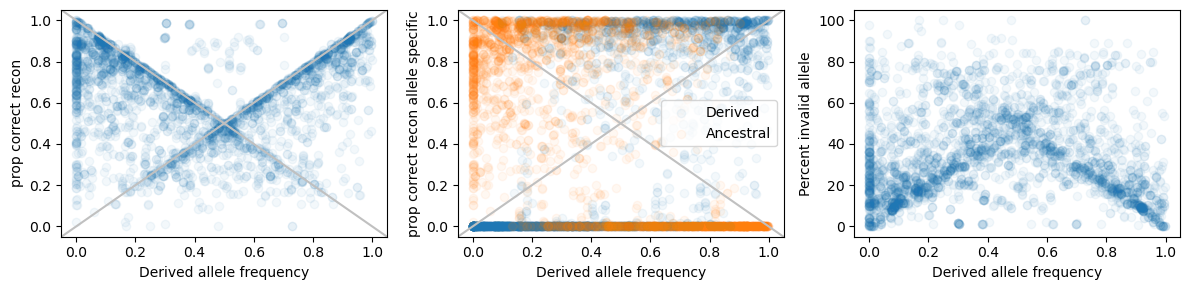

In [15]:
# Create a figure with 2 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 2 columns

# first plot
axes[0].scatter(dataset['daf'], dataset['correct_allele']/100, alpha=0.05)
axes[0].set_xlabel("Derived allele frequency")
axes[0].set_ylabel("prop correct recon")
axes[0].axline((1, 0), slope=-1, color = 'silver')
axes[0].axline((1, 1), slope=1, color = 'silver')


# second plot
axes[1].scatter(dataset['daf'], (dataset['correct_allele_1'])/(1500*dataset['daf']), label='Derived', alpha=0.05)
axes[1].scatter(dataset['daf'], (dataset['correct_allele_0'])/(1500*(1-dataset['daf'])), label='Ancestral', alpha=0.05)
axes[1].set_xlabel("Derived allele frequency")
axes[1].set_ylabel("prop correct recon allele specific")
axes[1].axline((1, 0), slope=-1, color = 'silver')
axes[1].axline((1, 1), slope=1, color = 'silver')
axes[1].legend()

# third plot
axes[2].scatter(dataset['daf'], dataset['invalid_state'], alpha=0.05)
axes[2].set_xlabel("Derived allele frequency")
axes[2].set_ylabel("Percent invalid allele")

# Adjust layout and spacing
plt.tight_layout()
plt.show()